# Troy Quicksall
# DSC 550
# Week 5

## 1. Get the stemmed data using the same process you did in Week 3.

### Convert all text to lowercase letters.

In [1]:
import pandas as pd
from textblob import TextBlob
review_df = pd.read_csv('labeledTrainData.tsv', sep='\t', on_bad_lines='skip')
# Converting review column to lower case
review_df['review'] = review_df['review'].str.lower()
review_df.head()

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,"\the classic war of the worlds\"" by timothy hi..."
2,7759_3,0,the film starts with a manager (nicholas bell)...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


### Remove punctuation and special characters from the text.

In [2]:
import re
# Using regex to remove everything that is not letter or number 
review_df['review'] = review_df.apply(lambda row: re.sub('[^A-Za-z0-9 ]+', '', row.review), axis=1)
review_df.head()

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,the classic war of the worlds by timothy hines...
2,7759_3,0,the film starts with a manager nicholas bell g...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


### Remove stop words

In [3]:
# Using NLTK stop workds and filtering them out of the review column
from nltk.corpus import stopwords
stopWords = stopwords.words("english")

# creating function for filtering out stop words
def remove_stop_words(review):
    review = ' '.join([word for word in review.split() if word not in stopWords])
    return review

review_df['review'] = review_df.review.apply(remove_stop_words)

### Apply NLTK’s PorterStemmer.

In [4]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
ps = PorterStemmer()

def apply_stemmer(review):
    result = ''
    for words in review.split():
        words = word_tokenize(words)
        for w in words:
            result = result + ps.stem(w) + ' '
    return result
  

review_df['review'] = review_df.review.apply(apply_stemmer)

review_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/troyquicksall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,sentiment,review
0,5814_8,1,stuff go moment mj ive start listen music watc...
1,2381_9,1,classic war world timothi hine entertain film ...
2,7759_3,0,film start manag nichola bell give welcom inve...
3,3630_4,0,must assum prais film greatest film opera ever...
4,9495_8,1,superbl trashi wondrous unpretenti 80 exploit ...


## 2. Split this into a training and test set.

In [5]:
# Creating x data of all variables not the target and separate target_data
x_data = review_df.drop(['sentiment', 'id'], axis=1)
target_data = review_df['sentiment']

In [6]:
# splitting the data using sklearn
from sklearn.model_selection import train_test_split

# using 20% as test size 
x_train, x_test, target_train, target_test = train_test_split(x_data, target_data, test_size=0.2, random_state=42)

## 3. Fit and apply the tf-idf vectorization to the training set.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)
# creating tf-idf matrix with review column
# fitting the vectorizer
feature_matrix = tfidf.fit_transform(x_train['review'])

feature_matrix.shape

(20000, 150000)

In [8]:
# Applying the vectorizer on the train set
x_train_transform = tfidf.transform(x_train['review'])

x_train_transform.shape

(20000, 150000)

## 4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [9]:
# Applying the vectorizer on the test set
x_test_transform = tfidf.transform(x_test['review'])

x_test_transform.shape

(5000, 150000)

We do not fit the vectorization to the test set because we want to see how the model performs on a data set that it wasn't trained on. If we fit the test set we couldn't get an accurate look at how well the model performs, because it would be overfit to the test set.

## 5. Train a logistic regression using the training data.

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr = LogisticRegression()

In [12]:
# Training the logistic regression model using train transfor and the train target data set
lr.fit(x_train_transform, target_train)

LogisticRegression()

## 6. Find the model accuracy on test set.

In [13]:
from sklearn.metrics import accuracy_score
# using the accuracy_score to get the model's accuracy
predictions = lr.predict(x_test_transform)

accuracy = accuracy_score(target_test, predictions)
print('Model accuracy: ', accuracy)

Model accuracy:  0.8886


As we can see the model has a prediction accuracy of 89%

## 7. Create a confusion matrix for the test set predictions

In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(target_test, predictions))

[[2154  327]
 [ 230 2289]]


## 8. Get the precision, recall, and F1-score for the test set predictions.

In [15]:
from sklearn.metrics import classification_report

# Getting accuracy of the model using predictions and the classifications report from sklearn
predictions = lr.predict(x_test_transform)
results = classification_report(target_test, predictions)
print(results)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2481
           1       0.88      0.91      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [16]:
# We can also calculate the values manually from the confusion matrix and compare
# Precision = True Positives / (True Positives + False Positives)
# Recall = True Positives / (True Positives + False Negatives)
# F1-score = 2 * (Precision * Recall) / (Precision + Recall)
 
matr = confusion_matrix(target_test, predictions)

In [17]:
precision = (matr[0][0])/(matr[0][0] + matr[0][1])

recall = (matr[0][0])/(matr[0][0] + matr[1][0])

f1 = (2 * (precision * recall))/(precision + recall)

print('precision: ', precision)
print('recall: ', recall)
print('f1-score: ', f1)

precision:  0.8681983071342201
recall:  0.9035234899328859
f1-score:  0.8855087358684481


## 9. Create a ROC curve for the test set.

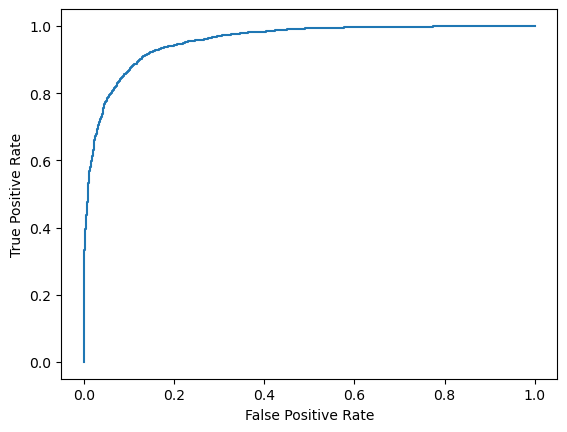

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt

# using predict_proba to get classification probabilities
test_predictions = lr.predict_proba(x_test_transform)[::,1]
# Using roc_curve to get true and false positives of predicitions 
false_positives, true_positives, _ = metrics.roc_curve(target_test,  test_predictions)

#plotting ROC curve
plt.plot(false_positives,true_positives)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The curve hugs the top left corner indicating good performance of the model.

## 10. Pick another classification model you learned about this week and repeat steps (5) – (9).

In [19]:
# Using SVM classification model
from sklearn import svm

classifier = svm.SVC(kernel='linear')



## 5. Train a logistic regression using the training data.

In [20]:
classifier.fit(x_train_transform, target_train)

SVC(kernel='linear')

## 6. Find the model accuracy on test set.

In [21]:
# generating predictions

svm_predictions = classifier.predict(x_test_transform)

accuracy_svm = accuracy_score(target_test, svm_predictions)
print('Model accuracy: ', accuracy_svm)

Model accuracy:  0.8938


## 7. Create a confusion matrix for the test set predictions.

In [22]:
print(confusion_matrix(target_test, svm_predictions))

[[2189  292]
 [ 239 2280]]


## 8. Get the precision, recall, and F1-score for the test set predictions.

In [23]:
# Getting accuracy of the model using predictions and the classifications report from sklearn
results_svm = classification_report(target_test, svm_predictions)
print(results_svm)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2481
           1       0.89      0.91      0.90      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [24]:

# Precision = True Positives / (True Positives + False Positives)
# Recall = True Positives / (True Positives + False Negatives)
# F1-score = 2 * (Precision * Recall) / (Precision + Recall)
 
matr_svm = confusion_matrix(target_test, svm_predictions)

precision_svm = (matr_svm[0][0])/(matr_svm[0][0] + matr_svm[0][1])

recall_svm = (matr_svm[0][0])/(matr_svm[0][0] + matr_svm[1][0])

f1_svm = (2 * (precision_svm * recall_svm))/(precision_svm + recall_svm)

print('precision: ', precision_svm)
print('recall: ', recall_svm)
print('f1-score: ', f1_svm)

precision:  0.8823055219669488
recall:  0.9015650741350906
f1-score:  0.8918313302098186


## 9. Creating ROC curve from test set

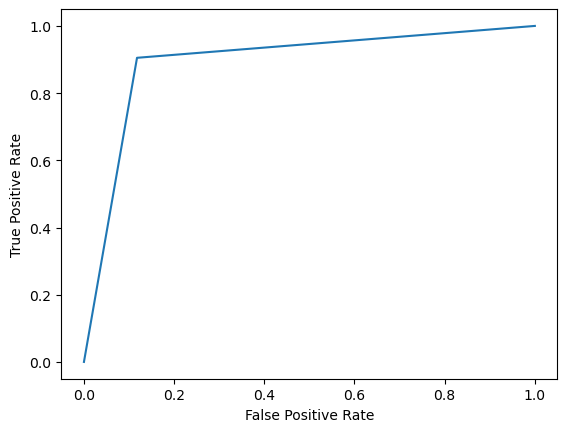

In [26]:

# Using roc_curve to get true and false positives of predicitions 
false_positives_svm, true_positives_svm, _ = metrics.roc_curve(target_test,  svm_predictions)

#plotting ROC curve
plt.plot(false_positives_svm,true_positives_svm)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()